<a href="https://colab.research.google.com/github/luke-stucky/spring2025/blob/main/LS_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# Packages for numerics + dataframes
import pandas as pd
import numpy as np

# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for Logistic Regression & Confusion Matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

In [19]:
from google.colab import files

uploaded = files.upload()

KeyboardInterrupt: 

In [20]:
df = pd.read_csv('waze_dataset.csv')  # Use the uploaded file path
print(df.shape)
df.info()
df.head()

(14999, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


In [21]:
df = df.drop('ID', axis=1)
df['label'].value_counts(normalize=True)
df.describe()

df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']
df['km_per_driving_day'].describe()
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0
df['km_per_driving_day'].describe()

df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)
print(df['professional_driver'].value_counts())
df.groupby(['professional_driver'])['label'].value_counts(normalize=True)

df = df.dropna(subset=['label'])

professional_driver
0    12405
1     2594
Name: count, dtype: int64


In [22]:
for column in ['sessions', 'drives', 'total_sessions', 'total_navigations_fav1',
               'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives']:
    threshold = df[column].quantile(0.95)
    df.loc[df[column] > threshold, column] = threshold

df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,76.539688,63.964683,183.717304,1751.822505,114.562767,27.187216,3944.558631,1792.911210,15.544653,12.182530,581.942399,0.173998
std,67.243178,55.127927,118.720520,1008.663834,124.378550,36.715302,2218.358258,1224.329759,9.016088,7.833835,1038.254509,0.379121
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000000
25%,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000,136.168003,0.000000
50%,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000,273.301012,0.000000
75%,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000,558.018761,0.000000
max,243.000000,200.000000,455.439492,3500.000000,422.000000,124.000000,8898.716275,4668.180092,31.000000,30.000000,15420.234110,1.000000


In [23]:
df['label2'] = np.where(df['label']=='churned', 1, 0)
df[['label', 'label2']].tail()

df['device2'] = np.where(df['device']=='Android', 0, 1)
df[['device', 'device2']].tail()

,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


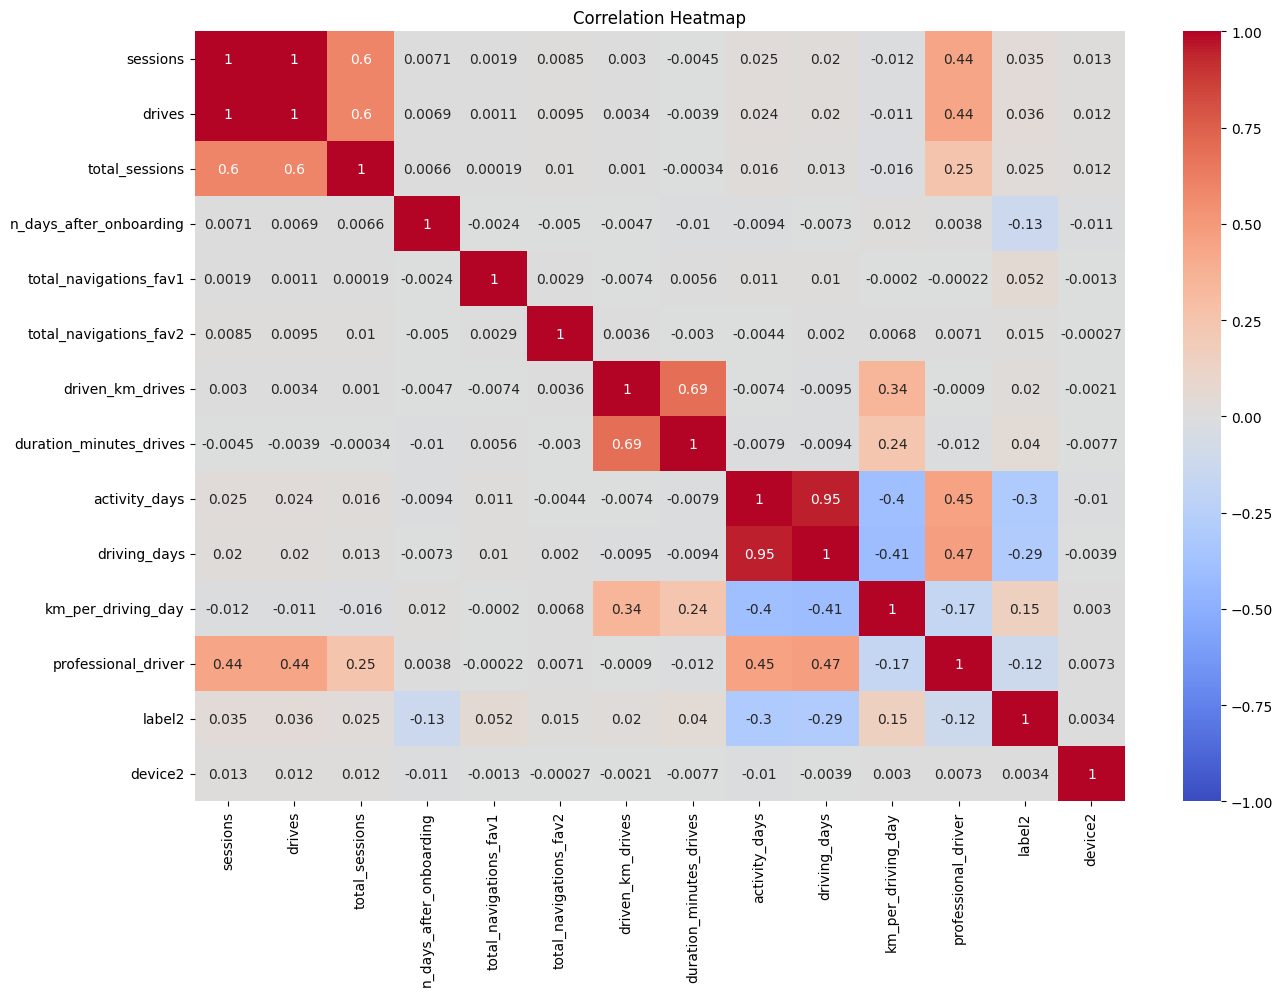

In [26]:
correlation_matrix.fillna(0, inplace=True)  # Replace NaNs with 0
correlation_matrix.replace([np.inf, -np.inf], 0, inplace=True)
plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [27]:
X = df.drop(columns = ['label', 'label2', 'device', 'sessions', 'driving_days'])
y = df['label2']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
X_train.head()

,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,km_per_driving_day,professional_driver,device2
152,108,186.192746,3116,243,124,8898.716275,4668.180092,24,612.305861,1,1
11899,2,3.487590,794,114,18,3286.545691,1780.902733,5,3286.545691,0,1
10937,139,347.106403,331,4,7,7400.838975,2349.305267,15,616.736581,0,0
669,108,455.439492,2320,11,4,6566.424830,4558.459870,18,410.401552,1,1
8406,10,89.475821,2478,135,0,1271.248661,938.711572,27,74.779333,0,1


In [29]:
model = LogisticRegression(penalty=None, max_iter=400)
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=400, penalty=None)

              precision    recall  f1-score   support

    retained       0.83      0.98      0.90      2941
     churned       0.53      0.09      0.16       634

    accuracy                           0.82      3575
   macro avg       0.68      0.54      0.53      3575
weighted avg       0.78      0.82      0.77      3575



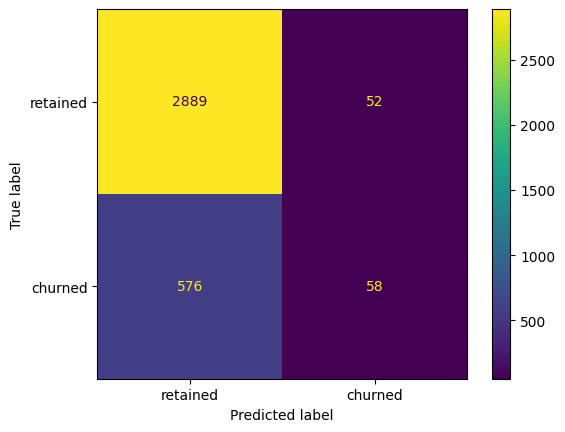

In [30]:
y_preds = model.predict(X_test)
cm = confusion_matrix(y_test, y_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['retained', 'churned'])
disp.plot()

print(classification_report(y_test, y_preds, target_names=['retained', 'churned']))

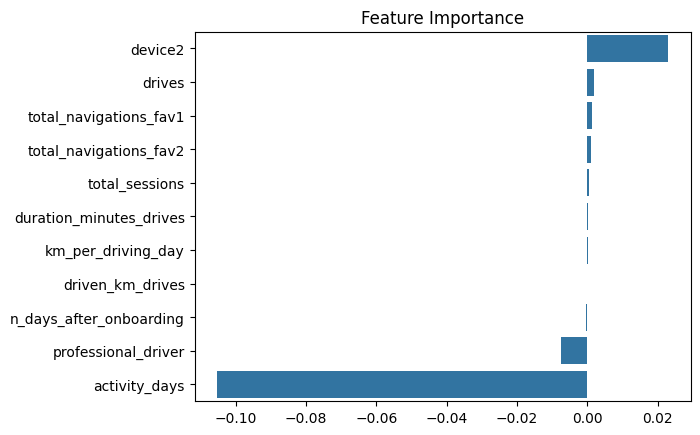

In [31]:
feature_importance = list(zip(X_train.columns, model.coef_[0]))
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)

sns.barplot(x=[x[1] for x in feature_importance],
            y=[x[0] for x in feature_importance],
            orient='h')
plt.title('Feature Importance')
plt.show()